# **PROGETTO DSL**

In [39]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [40]:
# Loading the dataset using Pandas dataframe
data_dev = pd.read_csv('datasets/development.csv')
data_dev = data_dev.drop(columns=['Id'])

labels = list(data_dev.columns.values)
labels.remove('gender')
labels.remove('ethnicity')

# First, let's convert tempo in a float data type
data_dev['tempo'] = data_dev['tempo'].str.replace('[','')
data_dev['tempo'] = data_dev['tempo'].str.replace(']','').astype(float)
data_dev

# Displaying the first 5 rows of the dataset
print(data_dev.head())

   sampling_rate   age  gender   ethnicity  mean_pitch  max_pitch  min_pitch  \
0          22050  24.0  female      arabic   1821.6906  3999.7170  145.43066   
1          22050  22.5  female   hungarian   1297.8187  3998.8590  145.37268   
2          22050  22.0  female  portuguese   1332.8524  3998.8025  145.42395   
3          22050  22.0  female     english   1430.3499  3998.4510  147.98083   
4          22050  22.0    male       dutch   1688.7234  3998.6113  145.44772   

     jitter   shimmer    energy  zcr_mean  spectral_centroid_mean       tempo  \
0  0.013795  0.082725  0.002254  0.210093             3112.257251  151.999081   
1  0.025349  0.096242  0.007819  0.078849             1688.016389  129.199219   
2  0.019067  0.119456  0.002974  0.105365             2576.901706  117.453835   
3  0.017004  0.102389  0.022371  0.173701             3269.751413  117.453835   
4  0.028027  0.124831  0.005369  0.107279             1930.897375  112.347147   

          hnr  num_words  num_ch

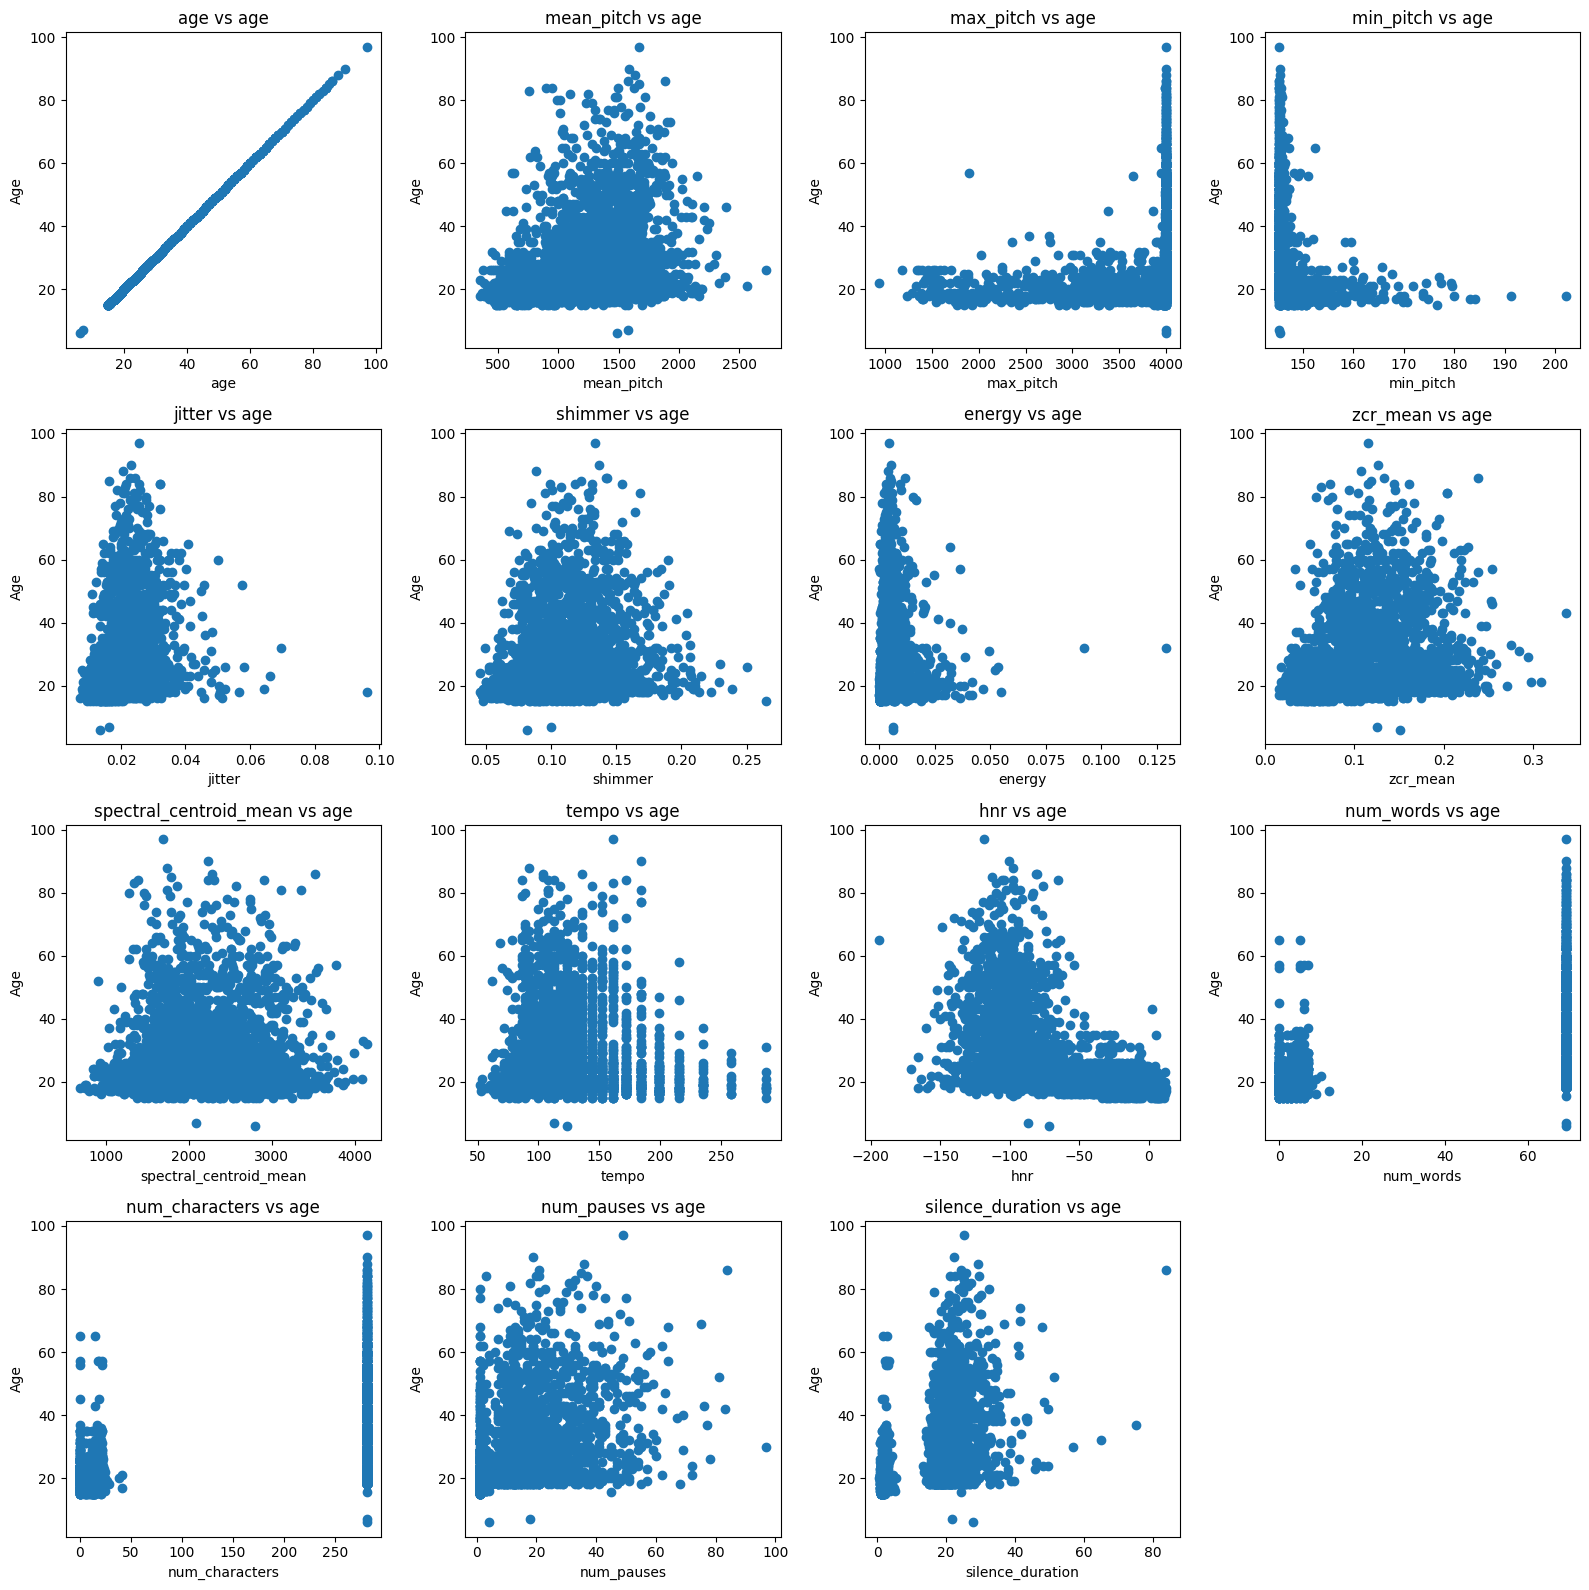

In [41]:
# scatterplot 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Scegli le colonne numeriche del tuo DataFrame
numerical_columns = data_dev.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns[~numerical_columns.isin(['sampling_rate'])]

cols_per_row = 4
rows = (len(numerical_columns) + cols_per_row - 1) // cols_per_row

# Crea una figura e una griglia di sottotrame
fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, 4 * rows))

# Flatten l'array di axes per facilitarne l'accesso
axes = axes.flatten()

# Plot ogni grafico
for i, column in enumerate(numerical_columns):
    # Creiamo un grafico per ogni colonna
    axes[i].scatter(data_dev[column], data_dev['age'])  # O qualsiasi altro tipo di grafico
    axes[i].set_title(f'{column} vs age')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Age')

# Se ci sono sottotrame non necessarie, le nascondiamo
for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

# Ottimizza il layout
plt.tight_layout()
plt.show()



In [42]:
# One-hot encoding for attribute gender and ethnicity
from collections import Counter
counts = dict(Counter(data_dev.ethnicity))
print('Numero di etnie', len(counts))

from sklearn.preprocessing import OneHotEncoder

# Crea il OneHotEncoder per "ethnicity"
all_categories_etn = sorted(set(data_dev['ethnicity']))
encoder_etn = OneHotEncoder(categories=[all_categories_etn], handle_unknown='ignore')
etn_encoded = encoder_etn.fit_transform(data_dev[['ethnicity']]).toarray()
etn_encoded_df = pd.DataFrame(etn_encoded, columns=['ethnicity_' + cat for cat in all_categories_etn])

# Crea il OneHotEncoder per "gender"
all_categories_gender = sorted(set(data_dev['gender']))
encoder_gender = OneHotEncoder(categories=[all_categories_gender], handle_unknown='ignore')
gender_encoded = encoder_gender.fit_transform(data_dev[['gender']]).toarray()
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['gender_' + cat for cat in all_categories_gender])

# Riuniamo il dataset
data_dev = pd.concat([data_dev.reset_index(drop=True).drop(columns=['ethnicity']), etn_encoded_df], axis=1)
data_dev = pd.concat([data_dev.reset_index(drop=True).drop(columns=['gender']), gender_encoded_df], axis=1)

data_dev

Numero di etnie 165


,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,ethnicity_sa'a,ethnicity_sardinian,ethnicity_sarua,ethnicity_satawalese,ethnicity_tiv,ethnicity_ukwani,ethnicity_urhobo,ethnicity_yoruba,gender_female,gender_male
0,22050,24.0,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22050,22.5,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,22050,22.0,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22050,22.0,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,22050,22.0,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,22050,24.0,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2929,22050,15.0,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2930,22050,17.0,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2931,22050,18.0,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.004451,0.115139,1834.596924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
# come useful libraries for deature extraction
import os
import librosa
import numpy as np

In [44]:
# function which reads a audio file and extract some useful spectral features 

def audio_feature_extraction(dataset):
    
    mfcc_list = []
    num_coeff_mfcc = 10

    # For each audio file we are going to extract the MFCC coefficients
    for sr, file_path in zip(dataset['sampling_rate'], dataset['path']):
        path = 'datasets/' + file_path
        print(path)
        
        # Reading the audio file 
        audio_time_series, sampling_rate = librosa.load(path = path, sr = sr)
        spectrogram = librosa.feature.melspectrogram(y= audio_time_series, sr= sampling_rate, n_mels=40)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Extracting MFCC coefficients
        mfcc = librosa.feature.mfcc(y= audio_time_series , sr= sampling_rate, n_mfcc= num_coeff_mfcc)  
        mfcc_list.append(np.mean(mfcc, axis = 1))
        
        
    # Converting the mfcc list in a dataframe to concatenate it to dataset
    mfcc_df = pd.DataFrame(mfcc_list, columns=[f'mfcc_{i+1}' for i in range(num_coeff_mfcc)])
    new_dataset = pd.concat([dataset, mfcc_df], axis=1)

    return new_dataset


In [45]:
data_dev = audio_feature_extraction(data_dev)

datasets/audios_development/1.wav
datasets/audios_development/2.wav
datasets/audios_development/3.wav
datasets/audios_development/4.wav
datasets/audios_development/5.wav
datasets/audios_development/6.wav
datasets/audios_development/7.wav
datasets/audios_development/8.wav
datasets/audios_development/9.wav
datasets/audios_development/10.wav
datasets/audios_development/11.wav
datasets/audios_development/12.wav
datasets/audios_development/13.wav
datasets/audios_development/14.wav
datasets/audios_development/15.wav
datasets/audios_development/16.wav
datasets/audios_development/17.wav
datasets/audios_development/18.wav
datasets/audios_development/19.wav
datasets/audios_development/20.wav
datasets/audios_development/21.wav
datasets/audios_development/22.wav
datasets/audios_development/23.wav
datasets/audios_development/24.wav
datasets/audios_development/25.wav
datasets/audios_development/26.wav
datasets/audios_development/27.wav
datasets/audios_development/28.wav
datasets/audios_development/2

In [46]:
# negletting the columns about num_charac and num_words and path for training the regression model
data_dev = data_dev.drop(columns = ['path'])
data_dev.head()

,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10
0,22050,24.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,...,-369.445770,55.719803,-20.172199,1.858431,-11.094159,-21.289921,-6.304841,-15.065480,-22.394070,-9.545800
1,22050,22.5,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,...,-291.229675,122.431274,-5.133554,40.160587,8.176783,-6.416771,-2.469234,-4.796830,3.619060,-9.030072
2,22050,22.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,...,-304.470520,72.080658,19.171961,23.241703,13.341725,6.166435,4.148386,1.036567,-8.732519,9.563400
3,22050,22.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,...,-254.585403,38.093533,27.635315,29.920998,-9.363325,-17.644960,-31.449722,-8.642945,-19.032154,-7.290901
4,22050,22.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,...,-273.523865,112.785225,-2.480324,33.589447,28.171324,-3.943830,-0.313671,13.828848,-18.041935,-1.688611


# **MODELLI**

In [47]:
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline


In [48]:
# Dividing the dataset into development and validation
X_train_valid, X_test, y_train_valid, y_test = train_test_split(data_dev.drop(columns=['age']), data_dev['age'], test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train_valid)
X_train_valid = scaler.transform(X_train_valid)
X_test = scaler.transform(X_test)

In [49]:
# Linear regressor with all features
model = LinearRegression(fit_intercept=True)

model.fit(X_train_valid, y_train_valid)
score = root_mean_squared_error(y_test, model.predict(X_test))
print('Root Mean Squared Error = ', score )

Root Mean Squared Error =  9.75413899648868


In [54]:
# random Forest with all features
model = RandomForestRegressor(max_depth= 100, min_samples_split=10, n_estimators=200)

model.fit(X_train_valid, y_train_valid)
score = root_mean_squared_error(y_test, model.predict(X_test))
print('Root Mean Squared Error = ', score )

Root Mean Squared Error =  9.48571221340231


In [51]:
# Elastic Net with all features
model = ElasticNet(alpha = 1, fit_intercept= False, l1_ratio=1, max_iter=5000, selection='cyclic')

model.fit(X_train_valid, y_train_valid)
score = root_mean_squared_error(y_test, model.predict(X_test))
print('Root Mean Squared Error = ', score )

Root Mean Squared Error =  29.58465882825395


# **PREVISIONE**

In [52]:
# Loading the evaluation dataset and preparing it for the prediction
data_eval = pd.read_csv('datasets/evaluation.csv')

data_eval['tempo'] = data_eval['tempo'].str.replace('[','')
data_eval['tempo'] = data_eval['tempo'].str.replace(']','').astype(float)

# encoding gender and etnhicity with the encoder preoviously created
# Encoding per "ethnicity"
etn_encoded = encoder_etn.transform(data_eval[['ethnicity']]).toarray()
etn_encoded_df = pd.DataFrame(etn_encoded, columns=['ethnicity_' + cat for cat in all_categories_etn])

# Encoding per "gender"
gender_encoded = encoder_gender.transform(data_eval[['gender']]).toarray()
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['gender_' + cat for cat in all_categories_gender])

# Riuniamo il dataset
data_eval = pd.concat([data_eval.reset_index(drop=True).drop(columns=['ethnicity']), etn_encoded_df], axis=1)
data_eval = pd.concat([data_eval.reset_index(drop=True).drop(columns=['gender']), gender_encoded_df], axis=1)

# Extracting features from the audio files
data_eval = audio_feature_extraction(data_eval)

data_eval = data_eval.drop(columns = ['path'])

datasets/audios_evaluation/1.wav
datasets/audios_evaluation/2.wav
datasets/audios_evaluation/3.wav
datasets/audios_evaluation/4.wav
datasets/audios_evaluation/5.wav
datasets/audios_evaluation/6.wav
datasets/audios_evaluation/7.wav
datasets/audios_evaluation/8.wav
datasets/audios_evaluation/9.wav
datasets/audios_evaluation/10.wav
datasets/audios_evaluation/11.wav
datasets/audios_evaluation/12.wav
datasets/audios_evaluation/13.wav
datasets/audios_evaluation/14.wav
datasets/audios_evaluation/15.wav
datasets/audios_evaluation/16.wav
datasets/audios_evaluation/17.wav
datasets/audios_evaluation/18.wav
datasets/audios_evaluation/19.wav
datasets/audios_evaluation/20.wav
datasets/audios_evaluation/21.wav
datasets/audios_evaluation/22.wav
datasets/audios_evaluation/23.wav
datasets/audios_evaluation/24.wav
datasets/audios_evaluation/25.wav
datasets/audios_evaluation/26.wav
datasets/audios_evaluation/27.wav
datasets/audios_evaluation/28.wav
datasets/audios_evaluation/29.wav
datasets/audios_evaluat

In [55]:
# PREDICTION

# Standardize the data
scaler_eval = StandardScaler()
scaler_eval.fit(data_dev.drop(columns=['age']))
data_dev_scaled = scaler_eval.transform(data_dev.drop(columns=['age']))
data_eval_scaled = scaler_eval.transform(data_eval.drop(columns=['Id']))

best_model = RandomForestRegressor(max_depth= 100, min_samples_split=10, n_estimators=200)

best_model.fit(data_dev_scaled, data_dev['age'])
y_pred_eval = best_model.predict(data_eval_scaled)


# Writing the csv file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id_eval, age_pred in zip(data_eval['Id'], y_pred_eval):
        writer.writerow([id_eval, age_pred])

Con questo codice ho ottenuto 10.130 nella leaderboard.

API KEY MARTI: f3f355d153317d695a959131054e8c0d2bb8e5e3b24da9e96394875c3aef71fb